In [ ]:
import sys
print(sys.executable)


In [ ]:
!export KAGGLE_API_TOKEN=KGAT_a68598a40280c8278b102981394038ce

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# -------------------------------
# CONFIG
# -------------------------------
DATASET_DIR = "C:/Users/nvgok/OneDrive/Apps/AISOC/trybest/datasets"      # root folder of dataset
TARGET_SIZE = (32, 32)           # small size for FPGA CNN
OUTPUT_DIR = "C:/Users/nvgok/OneDrive/Apps/AISOC/trybest/data_fpga"  # save processed dataset
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------
# UTILITY FUNCTION: Resize + pad + convert to 8-bit
# -------------------------------
def resize_and_int8(img, target_size=(32, 32)):
    img = img.convert("RGB")  # force RGB
    w, h = img.size
    scale = min(target_size[0]/w, target_size[1]/h)
    new_w, new_h = int(w*scale), int(h*scale)
    img_resized = img.resize((new_w, new_h), Image.LANCZOS)
    
    # pad with black to keep aspect ratio
    new_img = Image.new("RGB", target_size)
    top = (target_size[1] - new_h)//2
    left = (target_size[0] - new_w)//2
    new_img.paste(img_resized, (left, top))
    
    # convert to uint8 (0-255) for FPGA fixed point
    img_array = np.array(new_img, dtype=np.uint8)
    return img_array

# -------------------------------
# LOAD DATA
# -------------------------------
images = []
labels = []
class_names = []

for idx, class_folder in enumerate(sorted(os.listdir(DATASET_DIR))):
    class_path = os.path.join(DATASET_DIR, class_folder)
    if not os.path.isdir(class_path):
        continue
    class_names.append(class_folder)
    
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    img_array = resize_and_int8(img, TARGET_SIZE)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")

images = np.array(images, dtype=np.uint8)  # (N, H, W, 3)
labels = np.array(labels, dtype=np.uint8)  # (N,)

print(f"Total images: {len(images)}, Classes: {class_names}")

# -------------------------------
# SPLIT TRAIN/TEST
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# -------------------------------
# SAVE DATA
# -------------------------------
np.savez_compressed(os.path.join(OUTPUT_DIR, "train.npz"), X=X_train, y=y_train)
np.savez_compressed(os.path.join(OUTPUT_DIR, "test.npz"), X=X_test, y=y_test)

print("Processed dataset saved to:", OUTPUT_DIR)

Images shape: (8824, 32, 32, 3)
Labels shape: (8824,)
Unique labels: [0 1 2 3 4]


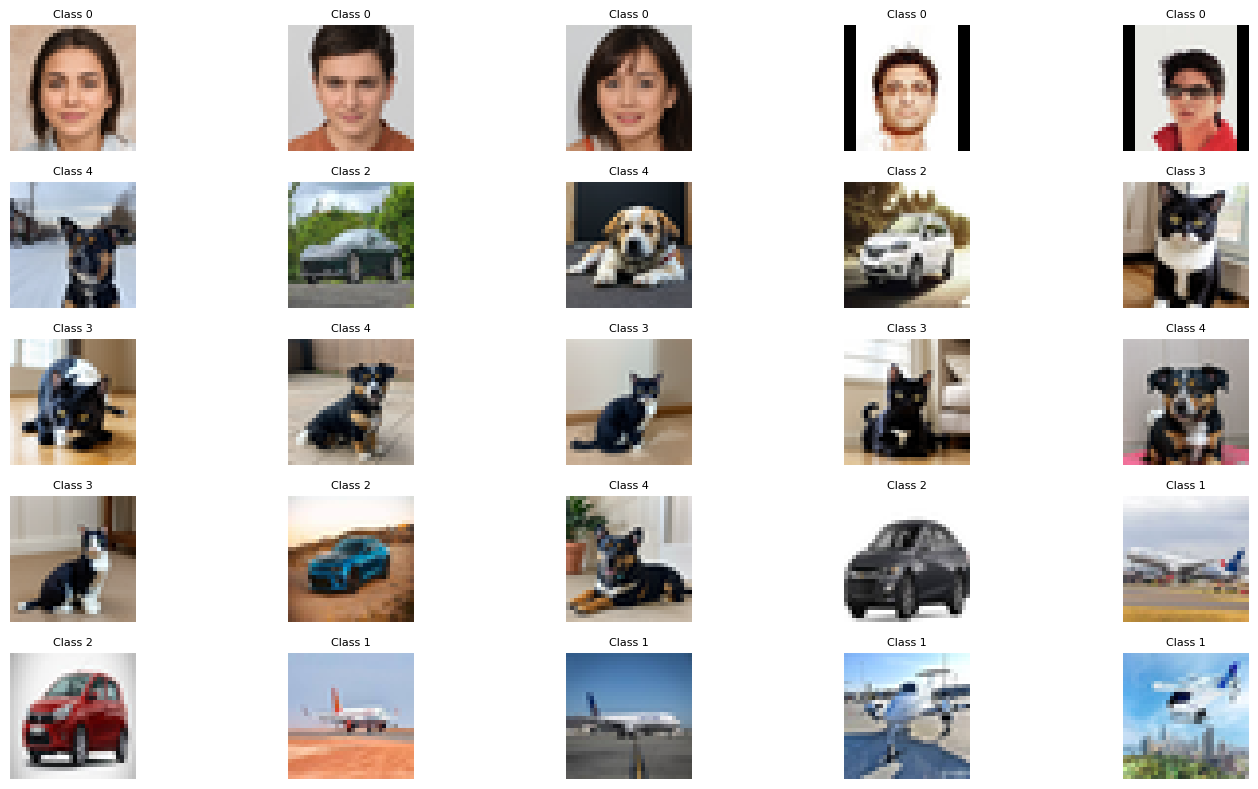

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load("data_fpga/train.npz")
X = data['X']  # images
y = data['y']  # labels

print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))

# Number of images to show per class
num_show = 5
classes = np.unique(y)
plt.figure(figsize=(15, 8))

plot_idx = 1
shown_per_class = {c: 0 for c in classes}

for img, label in zip(X, y):
    if shown_per_class[label] < num_show:
        plt.subplot(len(classes), num_show, plot_idx)
        plt.imshow(img.astype(np.uint8))
        plt.title(f"Class {label}", fontsize=8)
        plt.axis("off")
        plot_idx += 1
        shown_per_class[label] += 1
    
    if all(v >= num_show for v in shown_per_class.values()):
        break

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
from PIL import Image
import os

# Directory with 5 images
img_dir = "images"
output_dir = "bin_images"
os.makedirs(output_dir, exist_ok=True)

for idx, fname in enumerate(sorted(os.listdir(img_dir))):
    if fname.lower().endswith(('.png', '.jpg', '.bmp')):
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert('RGB').resize((32,32))
        img_array = np.array(img).astype(np.float32)/255.0  # normalize
        # Rearrange to [C][H][W]
        img_array = np.transpose(img_array, (2,0,1))
        # Save to .bin
        img_array.tofile(os.path.join(output_dir, f"image_{idx}.bin"))